In [1]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
df = pd.read_excel("drive/MyDrive/dataset.xlsx",parse_dates=True)

df

,order_date,formatted_date,pizza_name_id,quantity,unit_price,order_day,order_month,order_year,order_hour
0,2015-01-01,01 Jan 2015,hawaiian_m,1,13.25,Thursday,January,2015,11
1,2015-01-01,01 Jan 2015,peppr_salami_m,1,16.50,Thursday,January,2015,17
2,2015-01-01,01 Jan 2015,ckn_alfredo_m,1,16.75,Thursday,January,2015,17
3,2015-01-01,01 Jan 2015,ital_supr_m,1,16.50,Thursday,January,2015,17
4,2015-01-01,01 Jan 2015,peppr_salami_l,1,20.75,Thursday,January,2015,17
...,...,...,...,...,...,...,...,...,...
48615,2015-12-31,31 Dec 2015,spicy_ital_l,1,20.75,Thursday,December,2015,15
48616,2015-12-31,31 Dec 2015,calabrese_l,1,20.25,Thursday,December,2015,16
48617,2015-12-31,31 Dec 2015,classic_dlx_m,1,16.00,Thursday,December,2015,16
48618,2015-12-31,31 Dec 2015,mediterraneo_s,1,12.00,Thursday,December,2015,15


In [3]:
from statsmodels.tsa.stattools import adfuller
def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [4]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
#warnings.filterwarnings("ignore")
def select_arima(series):
    stepwise_fit = auto_arima(series,trace=True
                            )

    stepwise_fit.summary()
    order =stepwise_fit.get_params()['order']
    return order

In [5]:
import matplotlib.pyplot as plt
def plot(s1,s2,s3,s4):


  plt.figure(figsize=(12, 6))
  plt.plot(s1, s2, label='Actual Values', color='blue', marker='o')
  plt.plot(s3, s4, label='Forecasted Values', color='orange', linestyle='--', marker='x')

  # Adding titles and labels
  plt.title('Actual vs Forecasted Values')
  plt.xlabel('Date')
  plt.ylabel('Values')
  plt.xticks(rotation=45)
  plt.legend()
  plt.grid()
  plt.tight_layout()

  # Show plot
  plt.show()

In [6]:
import numpy as np
def wmape(y_true, y_pred):
    w= np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()
    return w

In [7]:
import joblib
from joblib import Parallel, delayed
from prophet.serialize import model_to_json, model_from_json
from prophet.diagnostics import mape
from statsmodels.tsa.arima.model import ARIMA
def run_one(train, valid, family):

    print('family:', family)

    train_ = train.groupby(['order_date', 'pizza_name_id']).agg({'quantity': 'sum'}).reset_index()


    valid_=valid.groupby(['order_date', 'pizza_name_id']).agg({'quantity': 'sum'}).reset_index()


    train_=train_[['order_date','quantity']]

    valid_=valid_[['order_date','quantity']]
    train_['order_date'] =pd.to_datetime(train_['order_date'])
    valid_['order_date'] = pd.to_datetime(valid_['order_date'])

    total_df = pd.concat([train_ , valid_])
    total_df['order_date'] = pd.to_datetime(total_df['order_date'])
    total_df.set_index('order_date', inplace=True)
    print("TOTAL",total_df['quantity'])

    adf_test(total_df['quantity'])
    arima_order = select_arima(total_df['quantity'])
    p , d, q =arima_order[0],arima_order[1],arima_order[2]


    model=ARIMA(train_['quantity'],order=(2,0,2))
    model=model.fit()
    print(model.summary())

    #prediction
    start=len(train_)
    end=end = len(train_) + len(valid_) -1
    #if the predicted values dont have date values as index, you will have to uncomment the following two commented lines to plot a graph
    index_future_dates=valid_['order_date']
    pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')


    pred.index=index_future_dates


    #print("final >>" ,final_df)

    print(valid_)
    acc = wmape(valid_['quantity'], pred.values)
    print('WMAPE:', acc)

    plot(valid_['order_date'],valid_['quantity'],valid_['order_date'],pred.values)



In [20]:
import joblib
from joblib import Parallel, delayed
from prophet.serialize import model_to_json, model_from_json
from prophet.diagnostics import mape
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd


def run_mul(train, valid, family):

    print('family:', family)

    train_ = train.groupby(['order_date', 'pizza_name_id']).agg({'quantity': 'sum'}).reset_index()


    valid_ = valid.groupby(['order_date', 'pizza_name_id']).agg({'quantity': 'sum'}).reset_index()


    train_ = train_[['order_date', 'quantity']]

    valid_ = valid_[['order_date', 'quantity']]
    train_['order_date'] = pd.to_datetime(train_['order_date'])
    valid_['order_date'] = pd.to_datetime(valid_['order_date'])

    total_df = pd.concat([train_, valid_])
    total_df['order_date'] = pd.to_datetime(total_df['order_date'])
    total_df.set_index('order_date', inplace=True)
    print("TOTAL", total_df['quantity'])

    # Check for constant values in the time series
    if total_df['quantity'].nunique() <= 1:
        print(f"Warning: Time series for family '{family}' is constant. Skipping ARIMA modeling.")
        # Return a DataFrame with NaN values to indicate failure
        final_df = pd.DataFrame({'order_date': valid_['order_date'], 'quantity': [float('nan')] * len(valid_), 'pizza_name_id': [family] * len(valid_)})
        return final_df

    adf_test(total_df['quantity'])
    arima_order = select_arima(total_df['quantity'])
    p, d, q = arima_order[0], arima_order[1], arima_order[2]


    model = ARIMA(train_['quantity'], order=(p, d, q))
    model = model.fit()
    print(model.summary())

    # prediction
    start = len(train_)
    end = len(train_) + len(valid_) - 1
    # if the predicted values dont have date values as index, you will have to uncomment the following two commented lines to plot a graph
    index_future_dates = valid_['order_date']
    pred = model.predict(start=start, end=end, typ='levels').rename('ARIMA predictions')


    pred.index = index_future_dates
    final_df = pd.DataFrame(list(pred.items()), columns=['order_date', 'quantity'])
    final_df['pizza_name_id'] = family
    return (final_df[['order_date', 'quantity', 'pizza_name_id']])

In [9]:
start_date =pd.to_datetime('2015-11-30')
train = df.loc[df['order_date'] <= start_date]
test = df.loc[df['order_date']> start_date]
train
test

,order_date,formatted_date,pizza_name_id,quantity,unit_price,order_day,order_month,order_year,order_hour
44998,2015-12-01,01 Dec 2015,spinach_fet_m,1,16.00,Tuesday,December,2015,17
44999,2015-12-01,01 Dec 2015,peppr_salami_m,1,16.50,Tuesday,December,2015,17
45000,2015-12-01,01 Dec 2015,bbq_ckn_l,1,20.75,Tuesday,December,2015,17
45001,2015-12-01,01 Dec 2015,bbq_ckn_l,1,20.75,Tuesday,December,2015,18
45002,2015-12-01,01 Dec 2015,spin_pesto_s,1,12.50,Tuesday,December,2015,18
...,...,...,...,...,...,...,...,...,...
48615,2015-12-31,31 Dec 2015,spicy_ital_l,1,20.75,Thursday,December,2015,15
48616,2015-12-31,31 Dec 2015,calabrese_l,1,20.25,Thursday,December,2015,16
48617,2015-12-31,31 Dec 2015,classic_dlx_m,1,16.00,Thursday,December,2015,16
48618,2015-12-31,31 Dec 2015,mediterraneo_s,1,12.00,Thursday,December,2015,15


In [10]:
test['order_date'].dtype

dtype('<M8[ns]')

<ipython-input-11-7bff39f615ca>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['order_date'] = pd.to_datetime(train_df['order_date'])
<ipython-input-11-7bff39f615ca>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['order_date'] = pd.to_datetime(test_df['order_date'])


family: hawaiian_m
TOTAL order_date
2015-01-01    1
2015-01-02    1
2015-01-04    1
2015-01-05    2
2015-01-06    1
             ..
2015-12-23    1
2015-12-24    1
2015-12-26    1
2015-12-27    1
2015-12-28    3
Name: quantity, Length: 270, dtype: int64
1. ADF :  -16.257950515661346
2. P-Value :  3.590001988769496e-29
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 269
5. Critical Values :
	 1% :  -3.4548957220044336
	 5% :  -2.8723451788613157
	 10% :  -2.572527778361272
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=775.399, Time=3.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=769.191, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=771.188, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=771.188, Time=0.98 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1155.461, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=773.191, Time=0.67 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  247
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -348.354
Date:                Sat, 02 Nov 2024   AIC                            708.708
Time:                        08:38:15   BIC                            729.764
Sample:                             0   HQIC                           717.185
                                - 247                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8023      0.091     19.805      0.000       1.624       1.981
ar.L1         -1.6629      0.044    -38.069      0.000      -1.748      -1.577
ar.L2         -0.9419      0.048    -19.628      0.0

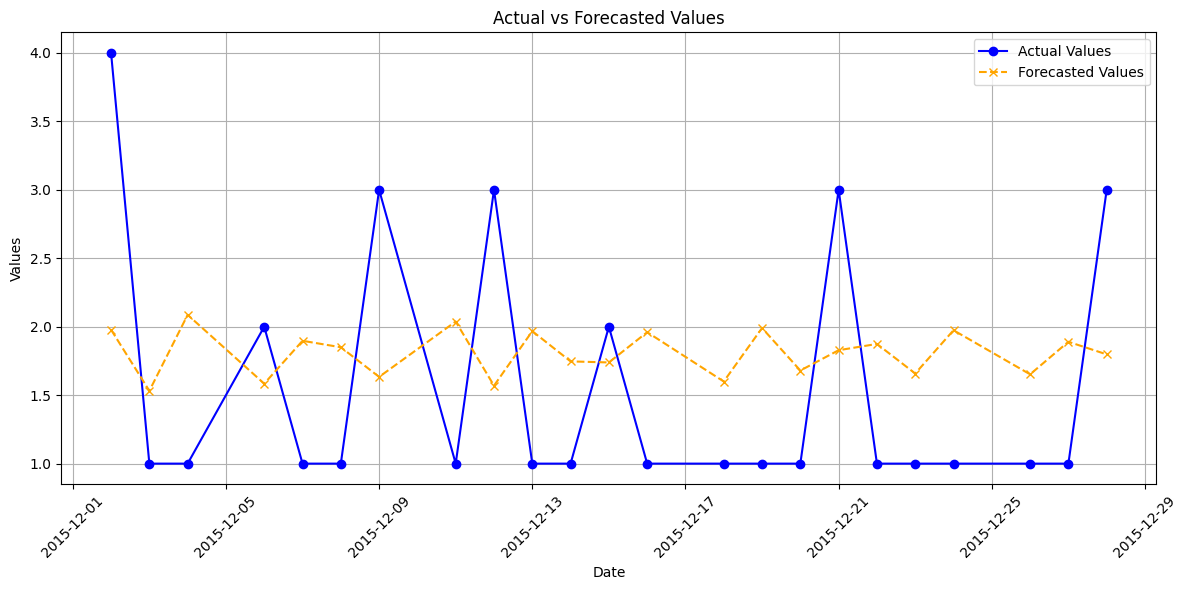

In [11]:
# for single pizza family
family = "hawaiian_m"
train_df = train.loc[train['pizza_name_id'] == family]
test_df = test.loc[test['pizza_name_id'] == family]
train_df['order_date'].dtype
train_df['order_date'] = pd.to_datetime(train_df['order_date'])
test_df['order_date'] = pd.to_datetime(test_df['order_date'])
train_df['order_date'].dtype
run_one(train_df,test_df,family)

In [21]:
jobs = list()
for family in train['pizza_name_id'].unique():
    train_df = train.loc[train['pizza_name_id'] == family]
    valid_df = test.loc[test['pizza_name_id'] == family]
    p = run_mul(train_df,valid_df,family)
    jobs.append(p)

family: hawaiian_m
TOTAL order_date
2015-01-01    1
2015-01-02    1
2015-01-04    1
2015-01-05    2
2015-01-06    1
             ..
2015-12-23    1
2015-12-24    1
2015-12-26    1
2015-12-27    1
2015-12-28    3
Name: quantity, Length: 270, dtype: int64
1. ADF :  -16.257950515661346
2. P-Value :  3.590001988769496e-29
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 269
5. Critical Values :
	 1% :  -3.4548957220044336
	 5% :  -2.8723451788613157
	 10% :  -2.572527778361272
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=775.399, Time=2.39 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=769.191, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=771.188, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=771.188, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1155.461, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=773.191, Time=0.15 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=675.227, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=670.793, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=672.724, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=672.726, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1060.474, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=674.682, Time=0.21 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.793 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  240
Model:                          ARIMA   Log Likelihood                -306.220
Date:                Sat, 02 Nov 2024   AIC                            616.441
Time:                        09:08:54   BIC                            623.402
Sample:                             0   HQIC                           619.246
                                - 240                     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1032.756, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1026.928, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1028.838, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1028.849, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1465.436, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1030.520, Time=0.18 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.652 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  281
Model:                          ARIMA   Log Likelihood                -472.088
Date:                Sat, 02 Nov 2024   AIC                            948.175
Time:                        09:08:55   BIC                            955.452
Sample:                             0   HQIC                           951.093
                                - 281                

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1224.149, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1221.080, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1222.603, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1222.658, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1724.763, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1221.102, Time=0.39 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.009 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  307
Model:                          ARIMA   Log Likelihood                -565.657
Date:                Sat, 02 Nov 2024   AIC                           1135.315
Time:                        09:08:56   BIC                           1142.768
Sample:                             0   HQIC                          1138.295
                                - 307                

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1031.382, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1026.685, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1028.573, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1028.568, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1453.401, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1030.582, Time=0.33 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.154 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  280
Model:                          ARIMA   Log Likelihood                -472.696
Date:                Sat, 02 Nov 2024   AIC                            949.391
Time:                        09:08:57   BIC                            956.661
Sample:                             0   HQIC                           952.307
                                - 280                

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=629.170, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=627.188, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=628.114, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=628.348, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=979.713, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=627.112, Time=1.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=627.617, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=627.219, Time=0.30 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=625.220, Time=0.12 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=627.219, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=628.861, Time=1.40 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=823.193, Time=0.05 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0] intercept
Total fit time: 4.098 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:       

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1518.419, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1515.627, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1516.239, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1516.203, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2023.144, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1518.165, Time=0.15 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.872 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  325
Model:                          ARIMA   Log Likelihood                -698.851
Date:                Sat, 02 Nov 2024   AIC                           1401.701
Time:                        09:09:03   BIC                           1409.269
Sample:                             0   HQIC                          1404.722
                                - 325                

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1296.789, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1290.315, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1290.803, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1290.811, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1784.966, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1292.803, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.416 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  306
Model:                          ARIMA   Log Likelihood                -593.901
Date:                Sat, 02 Nov 2024   AIC                           1191.801
Time:                        09:09:03   BIC                           1199.248
Sample:                             0   HQIC                          1194.779
                                - 306                

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1186.844, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1181.395, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1182.135, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1182.033, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1622.344, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1183.635, Time=0.21 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.861 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  290
Model:                          ARIMA   Log Likelihood                -544.816
Date:                Sat, 02 Nov 2024   AIC                           1093.633
Time:                        09:09:04   BIC                           1100.972
Sample:                             0   HQIC                          1096.573
                                - 290                

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=723.744, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=728.995, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=730.295, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=730.179, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1150.915, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=733.053, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=732.361, Time=0.25 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=726.757, Time=0.47 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=727.723, Time=0.54 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=731.996, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=726.926, Time=0.34 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=728.378, Time=0.36 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=726.880, Time=0.59 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 3.756 seconds
                

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=757.566, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=760.968, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=756.360, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=755.693, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1126.321, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=757.403, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=757.413, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=759.400, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=993.283, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.989 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  238
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -346.786
Date:                Sat, 02 Nov 2024   AIC                            699.572
Time:                

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1246.733, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1244.245, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1244.272, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1244.469, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1767.072, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1245.852, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.892 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  307
Model:                          ARIMA   Log Likelihood                -574.548
Date:                Sat, 02 Nov 2024   AIC                           1153.096
Time:                        09:09:10   BIC                           1160.550
Sample:                             0   HQIC                          1156.077
                                - 307                

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=697.597, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=692.340, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=694.304, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=694.308, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1086.230, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=695.671, Time=0.24 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.559 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  232
Model:                          ARIMA   Log Likelihood                -315.280
Date:                Sat, 02 Nov 2024   AIC                            634.559
Time:                        09:09:11   BIC                            641.453
Sample:                             0   HQIC                           637.339
                                - 232                     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=397.752, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=392.218, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=391.166, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=713.773, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=392.951, Time=0.35 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=392.936, Time=0.43 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=394.936, Time=0.74 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=637.869, Time=0.06 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 2.230 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  168
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -173.922
Date:                Sat, 02 Nov 2024   AIC                            353.845
Time:                     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


family: green_garden_s
TOTAL order_date
2015-01-01    5
2015-01-02    2
2015-01-03    3
2015-01-04    3
2015-01-05    1
             ..
2015-12-27    1
2015-12-28    2
2015-12-29    1
2015-12-30    2
2015-12-31    1
Name: quantity, Length: 297, dtype: int64
1. ADF :  -13.354247196304502
2. P-Value :  5.5895749427491605e-25
3. Num Of Lags :  1
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 295
5. Critical Values :
	 1% :  -3.452713099849546
	 5% :  -2.871387839457783
	 10% :  -2.5720171933352485
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=919.686, Time=3.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=920.757, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=921.553, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=921.144, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1342.957, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=919.838, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0] intercep

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=679.676, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=677.583, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=677.198, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=676.583, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1053.361, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=675.697, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=677.464, Time=0.24 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=677.463, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=675.895, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=676.571, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 1.406 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  233
Model:                 ARIMA(1, 0, 1)   Log Likelihoo

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=637.164, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=635.728, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=637.722, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=637.722, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=985.094, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=639.728, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.502 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  219
Model:                          ARIMA   Log Likelihood                -292.643
Date:                Sat, 02 Nov 2024   AIC                            589.286
Time:                        09:09:21   BIC                            596.064
Sample:                             0   HQIC                           592.023
                                - 219                      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1354.269, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1357.166, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1358.625, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1358.569, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1866.504, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1361.967, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1361.791, Time=0.15 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1357.163, Time=0.60 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1357.757, Time=0.55 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1360.420, Time=0.19 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1357.085, Time=0.27 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1358.782, Time=0.35 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=1358.171, Time=0.50 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.55 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 4.048 seconds
    

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1465.538, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1458.719, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1460.075, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1460.080, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2029.849, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1462.075, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.751 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  318
Model:                          ARIMA   Log Likelihood                -670.971
Date:                Sat, 02 Nov 2024   AIC                           1345.942
Time:                        09:09:26   BIC                           1353.466
Sample:                             0   HQIC                          1348.947
                                - 318                

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=429.855, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=426.871, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=427.763, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=427.775, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=800.786, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=429.754, Time=0.91 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.817 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  197
Model:                          ARIMA   Log Likelihood                -197.737
Date:                Sat, 02 Nov 2024   AIC                            399.475
Time:                        09:09:28   BIC                            406.041
Sample:                             0   HQIC                           402.133
                                - 197                      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=430.433, Time=3.28 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=429.586, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=431.150, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=431.177, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=778.940, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=432.999, Time=0.20 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 3.605 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  184
Model:                          ARIMA   Log Likelihood                -191.105
Date:                Sat, 02 Nov 2024   AIC                            386.209
Time:                        09:09:32   BIC                            392.639
Sample:                             0   HQIC                           388.816
                                - 184                      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=602.842, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=600.778, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=602.217, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=602.214, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=939.529, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=599.144, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=600.961, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=600.913, Time=0.21 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=604.204, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=604.215, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 1.585 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  209
Model:                 ARIMA(1, 0, 1)   Log Likelihood

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


TOTAL order_date
2015-01-01    3
2015-01-02    3
2015-01-03    3
2015-01-04    2
2015-01-05    4
             ..
2015-12-27    1
2015-12-28    1
2015-12-29    1
2015-12-30    1
2015-12-31    4
Name: quantity, Length: 336, dtype: int64
1. ADF :  -18.76260180862592
2. P-Value :  2.02614992140568e-30
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 335
5. Critical Values :
	 1% :  -3.4500219858626227
	 5% :  -2.870206553997666
	 10% :  -2.571387268879483
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1196.876, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1191.836, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1193.558, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1193.538, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1723.039, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1192.952, Time=0.42 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1430.198, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1427.994, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1429.066, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1429.017, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2041.913, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1430.913, Time=0.21 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.009 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  322
Model:                          ARIMA   Log Likelihood                -652.877
Date:                Sat, 02 Nov 2024   AIC                           1309.754
Time:                        09:09:36   BIC                           1317.303
Sample:                             0   HQIC                          1312.768
                                - 322                

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1255.644, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1255.315, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1255.806, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1255.711, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1737.880, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1257.603, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.884 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  309
Model:                          ARIMA   Log Likelihood                -583.067
Date:                Sat, 02 Nov 2024   AIC                           1170.133
Time:                        09:09:37   BIC                           1177.600
Sample:                             0   HQIC                          1173.119
                                - 309                

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1660.784, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1661.368, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1662.020, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1662.103, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2284.096, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1664.715, Time=0.60 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1665.676, Time=0.12 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1662.694, Time=0.60 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1662.664, Time=0.61 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1656.998, Time=0.28 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1663.720, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1663.676, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 3.458 seconds
                               SARIMAX Results                        

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1385.345, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1384.477, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1386.426, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1386.410, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1935.198, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1388.211, Time=0.77 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.490 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  323
Model:                          ARIMA   Log Likelihood                -632.742
Date:                Sat, 02 Nov 2024   AIC                           1269.483
Time:                        09:09:42   BIC                           1277.039
Sample:                             0   HQIC                          1272.499
                                - 323                

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1061.465, Time=2.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1055.343, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1056.520, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1056.519, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1501.119, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1058.519, Time=0.11 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 2.662 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  285
Model:                          ARIMA   Log Likelihood                -484.093
Date:                Sat, 02 Nov 2024   AIC                            972.186
Time:                        09:09:45   BIC                            979.491
Sample:                             0   HQIC                           975.114
                                - 285                

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1087.799, Time=1.57 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1085.153, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1086.825, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1086.846, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1504.693, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1088.773, Time=0.23 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.936 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  279
Model:                          ARIMA   Log Likelihood                -496.302
Date:                Sat, 02 Nov 2024   AIC                            996.604
Time:                        09:09:47   BIC                           1003.866
Sample:                             0   HQIC                           999.517
                                - 279                

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=594.690, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=590.284, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=592.265, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=592.261, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=919.374, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=591.436, Time=0.15 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.610 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  213
Model:                          ARIMA   Log Likelihood                -280.684
Date:                Sat, 02 Nov 2024   AIC                            565.368
Time:                        09:09:48   BIC                            572.091
Sample:                             0   HQIC                           568.085
                                - 213                      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=899.533, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=896.266, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=898.073, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=898.032, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1297.865, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=898.193, Time=0.37 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.989 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  263
Model:                          ARIMA   Log Likelihood                -404.664
Date:                Sat, 02 Nov 2024   AIC                            813.329
Time:                        09:09:49   BIC                            820.473
Sample:                             0   HQIC                           816.200
                                - 263                     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=926.607, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=928.297, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=928.520, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=928.342, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1352.913, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=929.143, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=931.603, Time=0.34 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=932.812, Time=0.42 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=933.023, Time=0.60 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=929.614, Time=0.26 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=933.710, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=933.602, Time=0.46 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 3.770 seconds
                    

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=840.606, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=842.424, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=842.417, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1220.548, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=843.717, Time=0.35 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.972 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  246
Model:                          ARIMA   Log Likelihood                -385.017
Date:                Sat, 02 Nov 2024   AIC                            774.034
Time:                        09:09:54   BIC                            781.045
Sample:                             0   HQIC                           776.857
                                - 246                         

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1265.995, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1264.312, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1262.874, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1262.615, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1746.886, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1264.468, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1264.373, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1264.601, Time=0.49 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1585.505, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 1.406 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  301
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -576.097
Date:                Sat, 02 Nov 2024   AIC                           1158.195
Time:        

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=427.664, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=422.492, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=424.191, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=424.149, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=692.655, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=425.920, Time=0.12 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.596 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  158
Model:                          ARIMA   Log Likelihood                -189.227
Date:                Sat, 02 Nov 2024   AIC                            382.454
Time:                        09:09:57   BIC                            388.579
Sample:                             0   HQIC                           384.942
                                - 158                      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=635.205, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=640.057, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=642.022, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=642.024, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=954.012, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=644.836, Time=1.31 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=644.999, Time=1.55 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=637.268, Time=1.85 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=643.995, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=645.451, Time=0.24 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=646.376, Time=0.33 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.44 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 7.634 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  203
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -287.429
Date:                Sat, 02 Nov 2024   AIC                            586.858
Time:                        09:10:05   BIC                            606.738
Sample:                             0   HQIC                           594.901
                                - 203                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7941      0.091     19.660      0.000       1.615       1.973
ar.L1          0.9145      0.067     13.610      0.000       0.783       1.046
ar.L2         -0.9483      0.066    -14.332      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=862.914, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=863.996, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=863.971, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1302.212, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=864.068, Time=0.37 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.038 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  270
Model:                          ARIMA   Log Likelihood                -391.826
Date:                Sat, 02 Nov 2024   AIC                            787.652
Time:                        09:10:06   BIC                            794.849
Sample:                             0   HQIC                           790.542
                                - 270                         

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1097.791, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1094.809, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1096.121, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1096.233, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1522.796, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1097.329, Time=0.18 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.822 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  285
Model:                          ARIMA   Log Likelihood                -496.564
Date:                Sat, 02 Nov 2024   AIC                            997.128
Time:                        09:10:07   BIC                           1004.433
Sample:                             0   HQIC                          1000.056
                                - 285                

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=638.205, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=638.095, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=640.063, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=640.060, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1008.868, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=642.083, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.661 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  227
Model:                          ARIMA   Log Likelihood                -295.261
Date:                Sat, 02 Nov 2024   AIC                            594.522
Time:                        09:10:07   BIC                            601.372
Sample:                             0   HQIC                           597.286
                                - 227                     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=651.093, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=652.793, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=652.775, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=989.208, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=654.594, Time=0.40 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.971 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  218
Model:                          ARIMA   Log Likelihood                -299.945
Date:                Sat, 02 Nov 2024   AIC                            603.890
Time:                        09:10:08   BIC                            610.659
Sample:                             0   HQIC                           606.625
                                - 218                          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1062.854, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1064.809, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1064.813, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1490.400, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1065.978, Time=0.37 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.067 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  280
Model:                          ARIMA   Log Likelihood                -487.673
Date:                Sat, 02 Nov 2024   AIC                            979.345
Time:                        09:10:10   BIC                            986.615
Sample:                             0   HQIC                           982.261
                                - 280                     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1250.934, Time=1.50 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1248.814, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1245.393, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1245.326, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1715.768, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1247.324, Time=0.31 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1247.325, Time=0.82 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1249.324, Time=1.70 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1599.674, Time=0.10 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 4.817 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  305
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -569.090
Date:                Sat, 02 Nov 2024   AIC                           1144.179
Time:        

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=873.776, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=874.385, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=874.152, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1308.538, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=876.007, Time=0.49 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 2.564 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  265
Model:                          ARIMA   Log Likelihood                -404.477
Date:                Sat, 02 Nov 2024   AIC                            812.954
Time:                        09:10:18   BIC                            820.113
Sample:                             0   HQIC                           815.830
                                - 265                         

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


1. ADF :  -14.44998559392747
2. P-Value :  7.12483309694622e-27
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 219
5. Critical Values :
	 1% :  -3.460567372610299
	 5% :  -2.874829809033386
	 10% :  -2.573853225954421
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=516.080, Time=1.84 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=510.397, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=512.391, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=512.391, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=847.059, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=514.392, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 2.015 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  204
Model:                          ARIMA   Log Likelihood      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=570.759, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=572.759, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=572.759, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=917.921, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=574.291, Time=0.25 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.819 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  208
Model:                          ARIMA   Log Likelihood                -261.484
Date:                Sat, 02 Nov 2024   AIC                            526.968
Time:                        09:10:21   BIC                            533.643
Sample:                             0   HQIC                           529.667
                                - 208                          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=882.680, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=880.632, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=881.306, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=881.042, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1262.957, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=882.701, Time=0.11 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.629 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  262
Model:                          ARIMA   Log Likelihood                -404.268
Date:                Sat, 02 Nov 2024   AIC                            812.537
Time:                        09:10:21   BIC                            819.674
Sample:                             0   HQIC                           815.405
                                - 262                     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=456.968, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=455.610, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=455.712, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=455.772, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=810.082, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=457.699, Time=0.16 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.747 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  199
Model:                          ARIMA   Log Likelihood                -212.733
Date:                Sat, 02 Nov 2024   AIC                            429.465
Time:                        09:10:22   BIC                            436.052
Sample:                             0   HQIC                           432.131
                                - 199                      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=96.450, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=97.081, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=95.928, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=94.172, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=269.277, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=95.111, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=94.685, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=96.683, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=206.278, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.552 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                   75
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 -40.848
Date:                Sat, 02 Nov 2024   AIC                             87.697
Time:                        

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1219.553, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1220.800, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1222.269, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1222.296, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1710.826, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1225.851, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1225.977, Time=0.27 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1226.641, Time=0.51 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1226.506, Time=0.52 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1224.224, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1225.233, Time=0.22 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1225.048, Time=0.29 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 3.722 seconds
         

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1217.878, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1215.784, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1217.622, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1217.580, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1719.649, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1215.826, Time=0.18 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.784 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  306
Model:                          ARIMA   Log Likelihood                -562.057
Date:                Sat, 02 Nov 2024   AIC                           1128.114
Time:                        09:10:28   BIC                           1135.561
Sample:                             0   HQIC                          1131.092
                                - 306                

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=549.695, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=477.020, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=547.700, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=464.274, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=448.244, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=428.860, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=430.755, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.97 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.65 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=426.867, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=446.245, Time=0.05 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=428.763, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=407

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=776.651, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=777.741, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=777.732, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1189.644, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=779.732, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.728 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  256
Model:                          ARIMA   Log Likelihood                -352.700
Date:                Sat, 02 Nov 2024   AIC                            709.401
Time:                        09:10:37   BIC                            716.491
Sample:                             0   HQIC                           712.252
                                - 256                         

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=210.675, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=210.051, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=209.846, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=209.895, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=442.374, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=211.843, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=211.843, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=213.843, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=302.252, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.591 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  116
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -92.651
Date:                Sat, 02 Nov 2024   AIC                            191.303
Time:                 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=707.184, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=707.889, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=709.795, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=709.818, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1094.304, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=705.371, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=704.571, Time=0.05 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=706.050, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=710.597, Time=0.20 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=707.260, Time=0.36 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=909.233, Time=0.04 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0] intercept
Total fit time: 1.264 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  240
Model:                 ARIMA(0, 0, 2)   Log Likel

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=730.881, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=724.283, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=725.722, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=725.717, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1125.065, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=727.717, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.465 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  238
Model:                          ARIMA   Log Likelihood                -329.392
Date:                Sat, 02 Nov 2024   AIC                            662.784
Time:                        09:10:39   BIC                            669.729
Sample:                             0   HQIC                           665.583
                                - 238                     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=651.575, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=651.981, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=646.099, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=645.613, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=988.906, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=647.577, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=647.578, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=649.579, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=866.052, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.558 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  225
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -302.540
Date:                Sat, 02 Nov 2024   AIC                            611.079
Time:                 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


family: classic_dlx_s
TOTAL order_date
2015-01-01    2
2015-01-02    4
2015-01-03    2
2015-01-04    3
2015-01-05    2
             ..
2015-12-26    1
2015-12-27    2
2015-12-28    4
2015-12-29    1
2015-12-31    3
Name: quantity, Length: 310, dtype: int64
1. ADF :  -16.142955912220145
2. P-Value :  4.6551088314377874e-29
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 309
5. Critical Values :
	 1% :  -3.45169128009473
	 5% :  -2.8709394227049154
	 10% :  -2.5717780602423517
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1095.904, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1099.437, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1099.358, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1099.567, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1550.527, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1101.695, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0] inte

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  284
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -495.780
Date:                Sat, 02 Nov 2024   AIC                           1003.559
Time:                        09:10:49   BIC                           1025.453
Sample:                             0   HQIC                          1012.337
                                - 284                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6022      0.103     25.175      0.000       2.400       2.805
ar.L1         -1.0973      0.038    -28.775      0.000      -1.172      -1.023
ar.L2         -0.8615      0.037    -23.314      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=657.893, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=654.050, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=653.839, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=654.085, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1042.163, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=654.931, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=653.895, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=655.858, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=821.151, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.863 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  232
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -299.266
Date:                Sat, 02 Nov 2024   AIC                            604.533
Time:                

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=922.185, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=920.542, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=921.941, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=921.987, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1297.465, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=923.597, Time=0.22 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.863 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  267
Model:                          ARIMA   Log Likelihood                -434.630
Date:                Sat, 02 Nov 2024   AIC                            873.259
Time:                        09:10:52   BIC                            880.434
Sample:                             0   HQIC                           876.141
                                - 267                     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=653.236, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=649.819, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=649.507, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=649.368, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1040.063, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=651.002, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=651.167, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=651.977, Time=0.51 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=910.544, Time=0.05 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 1.419 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  230
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -290.334
Date:                Sat, 02 Nov 2024   AIC                            586.668
Time:                

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=714.125, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=706.151, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=708.151, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=708.151, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1095.027, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=710.151, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.359 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  241
Model:                          ARIMA   Log Likelihood                -314.011
Date:                Sat, 02 Nov 2024   AIC                            632.021
Time:                        09:10:54   BIC                            638.991
Sample:                             0   HQIC                           634.829
                                - 241                     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=93.571, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=94.915, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=94.725, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=273.097, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=96.527, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.378 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                   76
Model:                          ARIMA   Log Likelihood                 -43.840
Date:                Sat, 02 Nov 2024   AIC                             91.681
Time:                        09:10:54   BIC                             96.342
Sample:                             0   HQIC                            93.544
                                 - 76                              

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1079.668, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1074.612, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1076.547, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1076.537, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1507.084, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1078.289, Time=0.22 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.559 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  284
Model:                          ARIMA   Log Likelihood                -498.879
Date:                Sat, 02 Nov 2024   AIC                           1001.757
Time:                        09:10:55   BIC                           1009.055
Sample:                             0   HQIC                          1004.683
                                - 284                

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=416.887, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=412.281, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=411.998, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=412.094, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=709.966, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=413.916, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=413.004, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=414.987, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=538.533, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.851 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  166
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -176.864
Date:                Sat, 02 Nov 2024   AIC                            359.729
Time:                 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1089.405, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1002.949, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1087.406, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=964.697, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=951.599, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=937.342, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=919.198, Time=0.11 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=917.199, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=935.344, Time=0.08 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=893.991, Time=0.26 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=892.085, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0]             : 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=887.619, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=880.179, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=882.134, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=882.134, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1284.820, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=884.135, Time=0.32 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.952 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  264
Model:                          ARIMA   Log Likelihood                -395.388
Date:                Sat, 02 Nov 2024   AIC                            794.777
Time:                        09:11:02   BIC                            801.929
Sample:                             0   HQIC                           797.651
                                - 264                     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=271.897, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=267.296, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=269.025, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=269.003, Time=0.97 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=512.132, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=267.985, Time=0.15 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.900 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  133
Model:                          ARIMA   Log Likelihood                -126.384
Date:                Sat, 02 Nov 2024   AIC                            256.767
Time:                        09:11:04   BIC                            262.548
Sample:                             0   HQIC                           259.116
                                - 133                      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=725.020, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=726.512, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=726.489, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1130.347, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=726.909, Time=0.36 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.021 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  244
Model:                          ARIMA   Log Likelihood                -334.016
Date:                Sat, 02 Nov 2024   AIC                            672.031
Time:                        09:11:06   BIC                            679.025
Sample:                             0   HQIC                           674.848
                                - 244                         

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=497.228, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=498.878, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=499.519, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=499.599, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=798.418, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=501.703, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=502.834, Time=0.15 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=498.063, Time=0.30 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=497.634, Time=0.24 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=501.510, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=496.338, Time=0.21 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=497.353, Time=0.06 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=497.162, Time=0.34 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=500.966, Time=0.06 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=496.407, Time=0.09 sec
 ARIMA(2,0,4)(0,0,0)[0] i

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


-2.873032730098417
	 10% :  -2.572894516864816
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=781.483, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=777.883, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=779.015, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=779.071, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1112.733, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=780.264, Time=0.23 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.849 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  236
Model:                          ARIMA   Log Likelihood                -359.946
Date:                Sat, 02 Nov 2024   AIC                            723.893
Time:                        09:11:10   BIC                            730.820
Sample:                             0   HQIC   

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=359.536, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=357.580, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=359.360, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=359.327, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=679.069, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=359.267, Time=0.27 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.834 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  170
Model:                          ARIMA   Log Likelihood                -166.765
Date:                Sat, 02 Nov 2024   AIC                            337.529
Time:                        09:11:10   BIC                            343.801
Sample:                             0   HQIC                           340.074
                                - 170                      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=470.396, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=463.493, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=465.348, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=465.361, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=731.079, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=467.291, Time=0.11 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.392 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  175
Model:                          ARIMA   Log Likelihood                -217.912
Date:                Sat, 02 Nov 2024   AIC                            439.823
Time:                        09:11:11   BIC                            446.153
Sample:                             0   HQIC                           442.391
                                - 175                      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=832.866, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=827.224, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=827.915, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=827.980, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1257.044, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=829.734, Time=0.17 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.768 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  260
Model:                          ARIMA   Log Likelihood                -379.942
Date:                Sat, 02 Nov 2024   AIC                            763.883
Time:                        09:11:12   BIC                            771.005
Sample:                             0   HQIC                           766.746
                                - 260                     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=599.548, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=601.540, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=601.539, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=984.051, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=603.535, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.636 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  222
Model:                          ARIMA   Log Likelihood                -279.461
Date:                Sat, 02 Nov 2024   AIC                            562.922
Time:                        09:11:13   BIC                            569.727
Sample:                             0   HQIC                           565.670
                                - 222                          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=868.545, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=801.986, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=866.547, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=775.378, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=763.390, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=756.366, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=744.405, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.00 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=742.407, Time=1.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=754.369, Time=0.20 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=715.541, Time=1.27 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=713.854, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=669.372, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=670.483, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=672.409, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=672.379, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1077.815, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=668.549, Time=0.48 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=668.201, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=669.323, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=672.713, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=669.695, Time=0.46 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=903.602, Time=0.04 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0] intercept
Total fit time: 1.911 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  245
Model:                 ARIMA(0, 0, 2)   Log Likel

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=414.086, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=416.693, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=418.477, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=418.362, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=747.565, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=415.420, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=415.953, Time=0.14 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=418.908, Time=0.51 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=418.870, Time=0.39 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=417.261, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=417.216, Time=0.38 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=417.508, Time=0.41 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=420.913, Time=0.45 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.34 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 3.512 seconds
                 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=613.217, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=614.194, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=616.176, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=616.172, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=976.442, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=616.598, Time=0.40 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=617.463, Time=0.33 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=616.371, Time=0.63 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=617.350, Time=0.15 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=616.317, Time=0.50 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=619.018, Time=0.72 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.04 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 7.073 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  215
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -276.921
Date:                Sat, 02 Nov 2024   AIC                            565.842
Time:                        09:11:34   BIC                            586.066
Sample:                             0   HQIC                           574.014
                                - 215                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7627      0.011    165.803      0.000       1.742       1.783
ar.L1          0.3375      0.615      0.549      0.583      -0.868       1.543
ar.L2          0.4859      0.570      0.852      0.3

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=429.669, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=429.214, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=429.740, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=429.906, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=774.429, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=431.396, Time=0.11 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.487 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  186
Model:                          ARIMA   Log Likelihood                -198.764
Date:                Sat, 02 Nov 2024   AIC                            401.527
Time:                        09:11:36   BIC                            407.979
Sample:                             0   HQIC                           404.142
                                - 186                      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=376.443, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=373.376, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=374.706, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=374.575, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=717.610, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=376.369, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.463 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  186
Model:                          ARIMA   Log Likelihood                -178.078
Date:                Sat, 02 Nov 2024   AIC                            360.155
Time:                        09:11:36   BIC                            366.607
Sample:                             0   HQIC                           362.770
                                - 186                      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=432.131, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=429.714, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=426.419, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=426.795, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=732.885, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=428.305, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=428.282, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=430.305, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=511.500, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.848 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  176
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -197.632
Date:                Sat, 02 Nov 2024   AIC                            401.264
Time:                 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


1. ADF :  -15.414480098857245
2. P-Value :  3.092354515636946e-28
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 262
5. Critical Values :
	 1% :  -3.455558114028747
	 5% :  -2.872635586277424
	 10% :  -2.572682677000175
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=741.117, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=742.620, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=742.633, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1136.839, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=744.614, Time=0.18 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.818 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  243
Model:                          ARIMA   Log Likelihood       

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=949.060, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=941.634, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=943.158, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=943.142, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1362.556, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=945.069, Time=0.16 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.412 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  266
Model:                          ARIMA   Log Likelihood                -430.376
Date:                Sat, 02 Nov 2024   AIC                            864.752
Time:                        09:11:39   BIC                            871.919
Sample:                             0   HQIC                           867.631
                                - 266                     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=424.390, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=421.378, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=418.797, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=418.482, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=749.608, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=420.391, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=420.396, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=422.396, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=633.916, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.669 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  183
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -190.542
Date:                Sat, 02 Nov 2024   AIC                            387.085
Time:                 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


family: soppressata_s
TOTAL order_date
2015-01-04    2
2015-01-07    2
2015-01-09    1
2015-01-10    1
2015-01-12    2
             ..
2015-12-21    2
2015-12-23    1
2015-12-27    1
2015-12-28    2
2015-12-31    1
Name: quantity, Length: 206, dtype: int64
1. ADF :  -16.03691379131852
2. P-Value :  5.972231003012461e-29
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 205
5. Critical Values :
	 1% :  -3.4626576734812318
	 5% :  -2.8757444215841326
	 10% :  -2.5743412314098753
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=421.442, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=416.549, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=415.736, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=415.657, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=765.947, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=417.655, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=440.645, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=438.020, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=438.485, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=438.384, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=739.036, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=436.760, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=438.753, Time=0.26 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=438.754, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=440.162, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=440.332, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 1.347 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  171
Model:                 ARIMA(1, 0, 1)   Log Likelihood

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=123.174, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=124.838, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=124.758, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=281.471, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=126.117, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.481 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                   80
Model:                          ARIMA   Log Likelihood                 -57.153
Date:                Sat, 02 Nov 2024   AIC                            118.306
Time:                        09:11:43   BIC                            123.070
Sample:                             0   HQIC                           120.216
                                 - 80                          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=240.350, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=239.356, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=241.287, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=241.276, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=514.995, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=243.169, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.510 seconds
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  131
Model:                          ARIMA   Log Likelihood                -107.826
Date:                Sat, 02 Nov 2024   AIC                            219.652
Time:                        09:11:43   BIC                            225.403
Sample:                             0   HQIC                           221.989
                                - 131                      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [22]:
jobs

[   order_date  quantity pizza_name_id
 0  2015-12-02  1.809712    hawaiian_m
 1  2015-12-03  1.809712    hawaiian_m
 2  2015-12-04  1.809712    hawaiian_m
 3  2015-12-06  1.809712    hawaiian_m
 4  2015-12-07  1.809712    hawaiian_m
 5  2015-12-08  1.809712    hawaiian_m
 6  2015-12-09  1.809712    hawaiian_m
 7  2015-12-11  1.809712    hawaiian_m
 8  2015-12-12  1.809712    hawaiian_m
 9  2015-12-13  1.809712    hawaiian_m
 10 2015-12-14  1.809712    hawaiian_m
 11 2015-12-15  1.809712    hawaiian_m
 12 2015-12-16  1.809712    hawaiian_m
 13 2015-12-18  1.809712    hawaiian_m
 14 2015-12-19  1.809712    hawaiian_m
 15 2015-12-20  1.809712    hawaiian_m
 16 2015-12-21  1.809712    hawaiian_m
 17 2015-12-22  1.809712    hawaiian_m
 18 2015-12-23  1.809712    hawaiian_m
 19 2015-12-24  1.809712    hawaiian_m
 20 2015-12-26  1.809712    hawaiian_m
 21 2015-12-27  1.809712    hawaiian_m
 22 2015-12-28  1.809712    hawaiian_m,
    order_date  quantity   pizza_name_id
 0  2015-12-01  1.6541

In [23]:
concatenated_df = pd.concat(jobs, ignore_index=True)

concatenated_df = concatenated_df.reset_index(drop=True)
concatenated_df

,order_date,quantity,pizza_name_id
0,2015-12-02,1.809712,hawaiian_m
1,2015-12-03,1.809712,hawaiian_m
2,2015-12-04,1.809712,hawaiian_m
3,2015-12-06,1.809712,hawaiian_m
4,2015-12-07,1.809712,hawaiian_m
...,...,...,...
1837,2015-12-26,1.305339,ital_veggie_l
1838,2015-12-30,1.305339,ital_veggie_l
1839,2015-12-31,1.305339,ital_veggie_l
1840,2015-12-04,NaN,the_greek_xxl


In [25]:
concatenated_df.sort_values(by=['order_date'])

,order_date,quantity,pizza_name_id
1207,2015-12-01,1.886550,bbq_ckn_s
558,2015-12-01,2.899671,bbq_ckn_m
582,2015-12-01,5.098832,big_meat_s
68,2015-12-01,2.863187,ital_supr_m
1805,2015-12-01,1.511956,mediterraneo_s
...,...,...,...
773,2015-12-31,2.077231,the_greek_xl
118,2015-12-31,2.328566,peppr_salami_l
264,2015-12-31,1.823892,classic_dlx_l
1771,2015-12-31,2.172927,veggie_veg_m


In [27]:
concatenated_df= concatenated_df.groupby(['order_date']).agg({'quantity': 'sum'}).reset_index()
concatenated_df

,order_date,quantity
0,2015-12-01,134.934607
1,2015-12-02,137.446920
2,2015-12-03,133.346704
3,2015-12-04,130.711688
4,2015-12-05,147.751890
5,2015-12-06,143.790675
6,2015-12-07,138.564972
7,2015-12-08,152.835761
8,2015-12-09,141.878971
9,2015-12-11,142.496671


In [28]:
test=test.groupby(['order_date']).agg({'quantity': 'sum'}).reset_index()
test

,order_date,quantity
0,2015-12-01,119
1,2015-12-02,130
2,2015-12-03,119
3,2015-12-04,120
4,2015-12-05,142
5,2015-12-06,131
6,2015-12-07,128
7,2015-12-08,144
8,2015-12-09,156
9,2015-12-11,153


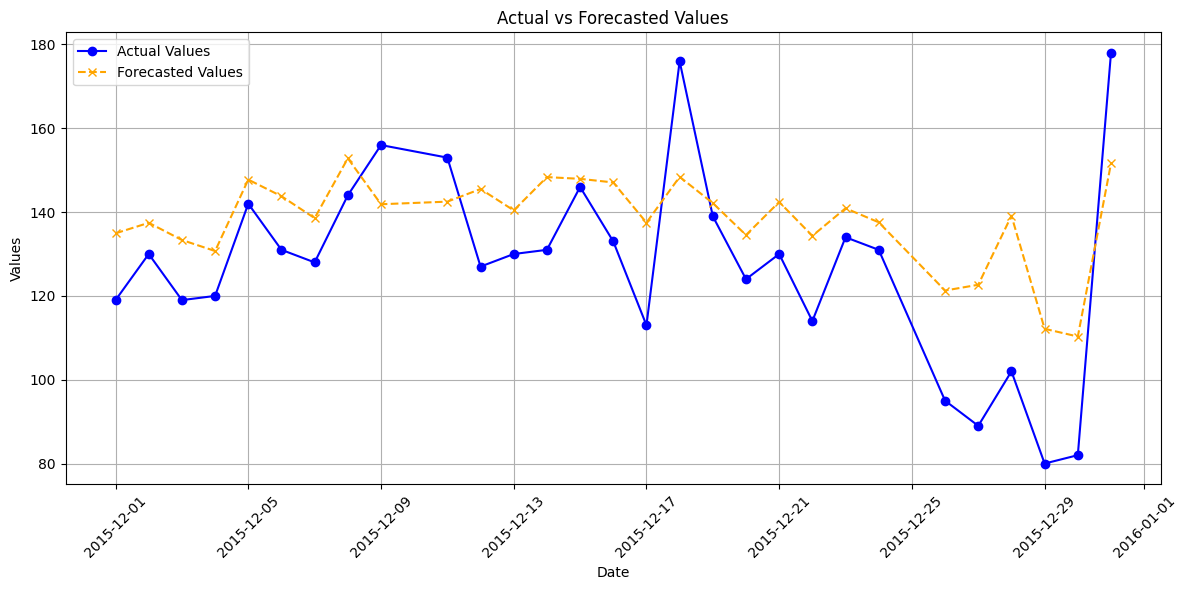

In [29]:
plot(test['order_date'],test['quantity'],concatenated_df['order_date'],concatenated_df['quantity'])

In [30]:
wmape(test['quantity'],concatenated_df['quantity'])

0.1269516738890912